In [1]:
#from pyomo.environ import ConcreteModel, Var, Objective, Constraint, ConstraintList, SolverFactory, NonNegativeReals, minimize, value
from pyomo.environ import *

import sys
import time
import pickle
import pandas as pd
import numpy as np

import math
import random
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Print versions of the imported libraries
print("Pyomo version:", pyomo.version.__version__)
# Print the Python version
print("Python version:", sys.version)

Pyomo version: 6.7.0
Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]


In [3]:
# Update font size globally
plt.rcParams.update({'font.size': 8})

# Set specific parameters for tick labels, axis labels, and legend
plt.rcParams.update({
    'axes.labelsize': 8,      # Axis labels
    'xtick.labelsize': 8,     # X-axis tick labels
    'ytick.labelsize': 8,     # Y-axis tick labels
    'legend.fontsize': 8,     # Legend text
    'lines.linewidth': 1,     # Line width
    'axes.titlesize': 8       # Title size
})

In [4]:
# load data
# electrical load in W
names = {0: 'Perfect', 1: 'Synth', 2: 'KNN', 3: 'Persistence', 4: 'xLSTM', 5: 'LSTM', 6: 'Transformer'}

with open('example_predictions.pkl', 'rb') as f: 
    (P_el_predicted, startdate) = pickle.load(f)
# energy price in €/Wh
with open('exaa_prices_1h.pkl', 'rb') as f:
    price = pickle.load(f)

In [5]:
price.shape

(2208,)

In [6]:
P_el_predicted = np.array(P_el_predicted)

In [7]:
P_el_predicted.shape

(7, 2208)

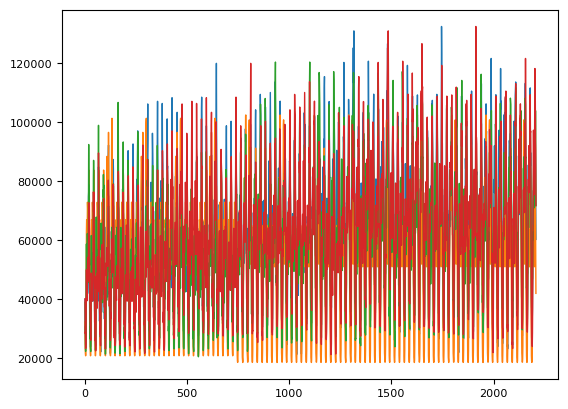

In [8]:
plt.plot(P_el_predicted[0,:])
plt.plot(P_el_predicted[1,:])
plt.plot(P_el_predicted[2,:])
plt.plot(P_el_predicted[3,:])

In [9]:
P_el_predicted[0,:].sum()

137808057.5015

In [10]:
price.mean()

8.887104347826086e-05

In [11]:
P_el_predicted[0,:].sum()*price.mean()

12247.145869870481

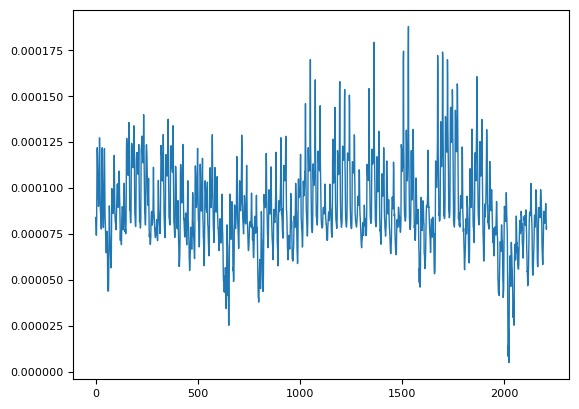

In [12]:
plt.plot(price)

In [13]:
P_el_real = P_el_predicted[0,:]
P_el_real.shape

(2208,)

In [14]:
startdate

Timestamp('2013-10-01 00:00:00+0000', tz='UTC')

## Reference

In [15]:
delta_t = 1
reference_costs = (price * P_el_real * delta_t).sum()
print(f"Non-optimized reference costs: {reference_costs:.2f} €")

Non-optimized reference costs: 12787.91 €


In [16]:
price.shape

(2208,)

In [17]:
P_el_real.shape

(2208,)

## Optimization

In [22]:
### Parameters
# Battery Energy Storage
C = 1000000.0   # Capacity (1MWh) in Wh
P_el_max = C / 4 # Maximum charge Power in W
eta_ch = 0.922
eta_dis = 0.922

# Number of different predictors
nb_preds = P_el_predicted.shape[0]

# Time parameters
time_steps_per_day = 24
test_days = int(P_el_predicted.shape[1] / time_steps_per_day)
delta_t = 1 # 1h

# Array to store the total costs for each predictor
sol_total_costs = np.zeros(nb_preds)

# Open-source solver HiGHS:
# https://github.com/ERGO-Code/HiGHS
# https://pyomo.readthedocs.io/en/6.8.0/library_reference/appsi/appsi.solvers.highs.html
solver = SolverFactory("appsi_highs")  

### Optimization Problem
for pred_type in range(nb_preds):
    # Initialize variables to store optimization results
    optimal_P_batt = np.zeros(test_days * time_steps_per_day)

    # Initial battery state (50% full)
    E_start = C / 2
    E_final = C / 2

    for day in range(test_days):
        start_hour = day * time_steps_per_day

        # Initialize Pyomo m
        m = ConcreteModel()
        m.T = range(time_steps_per_day)
        m.T_ext = range(time_steps_per_day + 1)

        # Define variables
        m.P_grid = Var(m.T, within=NonNegativeReals)
        m.P_ch = Var(m.T, bounds=(0, P_el_max))
        m.P_dis = Var(m.T, bounds=(0, P_el_max))
        m.E_batt = Var(m.T_ext, bounds=(0, C))
        
        m.b_ch = Var(m.T, within=Binary)
        m.b_dis = Var(m.T, within=Binary)

        # Objective function: minimize grid costs
        m.obj = Objective(
            expr=sum(price[start_hour + t] * m.P_grid[t] * delta_t for t in m.T),
            sense=minimize
        )

        # Constraints
        m.InitialSOC = Constraint(expr=m.E_batt[0] == E_start)
        m.FinalSOC = Constraint(expr=m.E_batt[time_steps_per_day] == E_final)

     #   m.PowerBase = ConstraintList()
        m.PowerBalance = ConstraintList()
        m.EnergyBalance = ConstraintList()
        m.ChargingIndicator = ConstraintList()
        m.DishargingIndicator = ConstraintList()
        m.SOS1 = ConstraintList()

        for t in m.T:
            # Power balance: power in = power out
         #   m.PowerBase.add(m.P_grid[t] >= 0.1*P_el_predicted[pred_type, start_hour + t])

            m.PowerBalance.add(m.P_grid[t] + m.P_dis[t] == m.P_ch[t] + P_el_predicted[pred_type, start_hour + t])
            # Energy balance of the battery
            m.EnergyBalance.add(m.E_batt[t + 1] == m.E_batt[t] + (m.P_ch[t]*eta_ch - m.P_dis[t]/eta_dis) * delta_t)

            # Binary variables to ensure that the battery cannot charge and discharge at the same time
            m.ChargingIndicator.add(m.P_ch[t] <= m.b_ch[t] * P_el_max)
            m.DishargingIndicator.add(m.P_dis[t] <= m.b_dis[t] * P_el_max)
            m.SOS1.add(m.b_ch[t] + m.b_dis[t] == 1)

        # Solve the m
        result = solver.solve(m)

        # Store Solutions
        for t in m.T:
            optimal_P_batt[start_hour + t] = value(m.P_ch[t]) - value(m.P_dis[t])
        E_start = value(m.E_batt[time_steps_per_day])
       
    # Final cost calculation without profit for feed-in (feed-in tariff = 0 €/Wh)
    # Calculate the resulting grid power for consumption
    P_total = np.maximum(optimal_P_batt + P_el_real, 0)
    costs_year = np.sum(P_total * price * delta_t)

    # Store the annual cost for the current predictor
    sol_total_costs[pred_type] = costs_year

### Results
# Comparison with reference costs
print(f"Non-optimized reference costs = {reference_costs:.2f} €")
print(42*'-')
for pred_type in range(nb_preds):
    print(f"Electricity costs for predictor {names[pred_type]:12s}= {sol_total_costs[pred_type]:.2f} €")
print(42*'-')
for pred_type in range(nb_preds):
    profit = reference_costs - sol_total_costs[pred_type]
    print(f"Profit for predictor {names[pred_type]:12s}= {profit:.2f} €")
print(42*'-')
for pred_type in range(nb_preds):
    profit = reference_costs - sol_total_costs[pred_type]
    print(f"Reduction for predictor {names[pred_type]:12s}= {profit/reference_costs*100:.2f} %")
print(42*'-')
for pred_type in range(1,nb_preds):
    profit = reference_costs - sol_total_costs[pred_type]
    print(f"Reduction for predictor {names[pred_type]:12s}= {profit/(reference_costs - sol_total_costs[0])*100:.2f} %")

Non-optimized reference costs = 12787.91 €
------------------------------------------
Electricity costs for predictor Perfect     = 11345.03 €
Electricity costs for predictor Synth       = 11632.05 €
Electricity costs for predictor KNN         = 11612.99 €
Electricity costs for predictor Persistence = 11645.09 €
Electricity costs for predictor xLSTM       = 11515.53 €
Electricity costs for predictor LSTM        = 11517.03 €
Electricity costs for predictor Transformer = 11484.07 €
------------------------------------------
Profit for predictor Perfect     = 1442.89 €
Profit for predictor Synth       = 1155.86 €
Profit for predictor KNN         = 1174.93 €
Profit for predictor Persistence = 1142.83 €
Profit for predictor xLSTM       = 1272.39 €
Profit for predictor LSTM        = 1270.89 €
Profit for predictor Transformer = 1303.85 €
------------------------------------------
Reduction for predictor Perfect     = 11.28 %
Reduction for predictor Synth       = 9.04 %
Reduction for predictor